In [1]:
import torch

## Download dataset

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.MNIST(root="data", train=True, transform=ToTensor(), download=True)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())

In [56]:
sub_train_data = torch.utils.data.Subset(train_data, range(10))

In [54]:
range(10)

range(0, 10)

## Visualization of dataset

In [4]:
import matplotlib.pyplot as plt

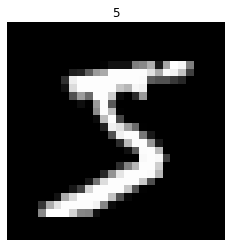

In [35]:
plt.imshow(train_data.data[0], cmap="gray")
plt.title("%i" % train_data.targets[0])
plt.axis("off")
plt.show()

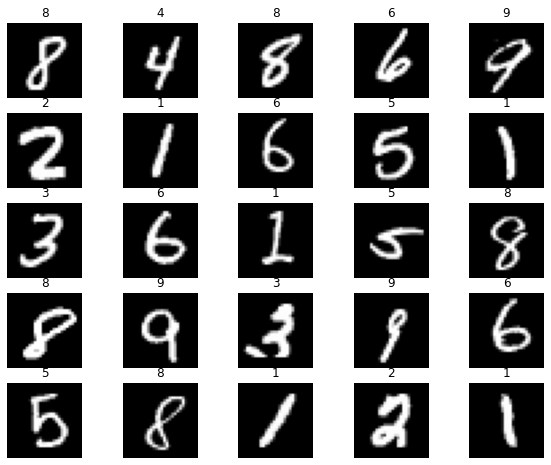

In [6]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Prepare data with DataLoaders

In [7]:
from torch.utils.data import DataLoader

In [8]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=10, 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=10, 
                                          shuffle=True, 
                                          num_workers=0),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fc072ee7820>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fc072ee77f0>}

## Define network

In [9]:
import torch.nn as nn

In [10]:
class Network1(nn.Module):
    
    def __init__(self, sizes):
        super(Network1, self).__init__()
        self.sizes = sizes
        layers = [
            nn.Sequential(
                nn.Linear(x, y),
                nn.Sigmoid(),
            )
            for x, y in zip(sizes[:-1], sizes[1:])
        ]
        for i in range(len(layers)):
            setattr(self, "layer{0}".format(i), layers[i])
                
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(len(self.sizes) - 1):
            layer = getattr(self, "layer{0}".format(i))
            x = layer(x)
        return x

In [11]:
net = Network1([784, 30, 10])
print(net)

Network1(
  (layer0): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=10, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
loss_fn = nn.MSELoss()
loss_fn

MSELoss()

In [13]:
from torch import optim

In [14]:
optimizer = optim.SGD(net.parameters(), lr=3.0)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 3.0
    momentum: 0
    nesterov: False
    weight_decay: 0
)

## Train

In [15]:
from torch.autograd import Variable
import torch.nn.functional as F

In [16]:
num_epochs = 30

In [17]:
def evaluate(net):
    net.eval()
    with torch.no_grad():
        total_correct = 0
        total_count = 0
        for images, labels in loaders['test']:
            test_output = net(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct = (pred_y == labels).sum().item()
            count = len(labels)
            total_correct += correct
            total_count += count
    return total_count, total_correct

In [18]:
def train(num_epochs, net, loaders):
    # Train the model
#     total_step = len(loaders['train'])
    total_step = 3
    
    steps = 0
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_count = 0
        
        net.train()
        
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)
            b_y = Variable(labels)
            output = net(b_x)
            b_y_encoded = F.one_hot(b_y, 10).float()
            
#             print(torch.max(output, 1))
#             print(torch.max(output, 1)[1])
#             print(torch.max(output, 1)[1].data)
            pred_y = torch.max(output, 1)[1].data.squeeze()
#             print(pred_y)
#             print(b_y)
#             print(pred_y == b_y)
            correct = (pred_y == labels).sum().item()
            correct = (pred_y == labels).sum().item()
            count = len(labels)
            total_correct += correct
            total_count += count
#             print()
            
            
            loss = loss_fn(output, b_y_encoded)
            total_loss += loss.item()
            
            # clear gradients for this training step
            optimizer.zero_grad()
            
            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()
            steps += 1
        
        eval_total_count, eval_correct = evaluate(net)
        print ('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.4f}, Eval Accuracy: {:.4f}'
                .format(epoch + 1, num_epochs, total_loss / steps, total_correct / total_count,
                        eval_correct / eval_total_count))

In [19]:
train(num_epochs, net, loaders)

Epoch [1/30], Loss: 0.0227, Train Accuracy: 0.8617, Eval Accuracy: 0.9276
Epoch [2/30], Loss: 0.0058, Train Accuracy: 0.9315, Eval Accuracy: 0.9354
Epoch [3/30], Loss: 0.0033, Train Accuracy: 0.9419, Eval Accuracy: 0.9430
Epoch [4/30], Loss: 0.0022, Train Accuracy: 0.9478, Eval Accuracy: 0.9470
Epoch [5/30], Loss: 0.0017, Train Accuracy: 0.9522, Eval Accuracy: 0.9492
Epoch [6/30], Loss: 0.0013, Train Accuracy: 0.9557, Eval Accuracy: 0.9516
Epoch [7/30], Loss: 0.0011, Train Accuracy: 0.9583, Eval Accuracy: 0.9522
Epoch [8/30], Loss: 0.0009, Train Accuracy: 0.9603, Eval Accuracy: 0.9537
Epoch [9/30], Loss: 0.0007, Train Accuracy: 0.9622, Eval Accuracy: 0.9575
Epoch [10/30], Loss: 0.0006, Train Accuracy: 0.9636, Eval Accuracy: 0.9562
Epoch [11/30], Loss: 0.0006, Train Accuracy: 0.9643, Eval Accuracy: 0.9569
Epoch [12/30], Loss: 0.0005, Train Accuracy: 0.9657, Eval Accuracy: 0.9588
Epoch [13/30], Loss: 0.0005, Train Accuracy: 0.9672, Eval Accuracy: 0.9573
Epoch [14/30], Loss: 0.0004, Train

## Evaluate the model

In [57]:
sample = next(iter(loaders['test']))
images, labels = sample

In [58]:
images.size()

torch.Size([10, 1, 28, 28])

In [ ]:
images

In [28]:
labels.size()

torch.Size([10])

In [21]:
actual_number = labels[:10].numpy()
actual_number

array([4, 3, 4, 7, 5, 0, 3, 7, 6, 3])

In [26]:
test_output = net(images[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction: {pred_y}')
print(f'Actual    : {actual_number}')

Prediction: [4 3 4 7 5 0 3 7 6 3]
Actual    : [4 3 4 7 5 0 3 7 6 3]


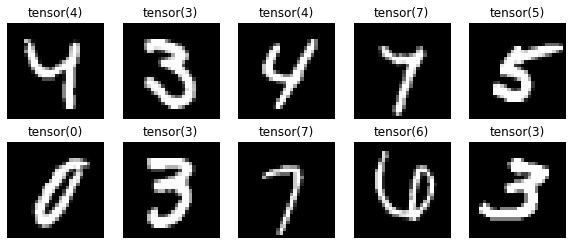

In [42]:
figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for i in range(cols * rows):
    img = images[i]
    label = labels[i]
#     img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()